In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib

In [5]:
def eig_e_corr(d,rho):
    """Returns normalized eigenvalues of d^2 x d^2 dimensional exponential correlation matrix with correlation coefficient rho"""
    ec_Mat = np.zeros((d**2,d**2))
    for x in range(0,d**2):
        for y in range(0,d**2):
            ec_Mat[x,y] = rho**(abs(x - y))
    eig_e = np.linalg.eig(ec_Mat)
    eig_e = eig_e[0]/np.sum(eig_e[0])
    return(eig_e)

def OPE_DWC(A):
    import numpy as np
    Pxy, pp, N = A[0], A[1], A[2]
    d = len(Pxy)
    #Pxy.setflags(write=1)
    Pxy[Pxy<0] = 0
    Pxy[Pxy>1] = 1
    noise_dist = (1-pp)*Pxy + pp*np.ones(Pxy.size)/d
    return (np.random.multinomial(N, noise_dist)/N)

def empVar(AA):
    import numpy as np
    x_obs, M, N_vals, kkk = AA[0], AA[1], AA[2], AA[3]
    emp_var = np.var([[x_obs[ii+kk*M][kkk].tolist() for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return emp_var

def mmse(AA):
    import numpy as np
    x_obs, M, N_vals, kkk, aaa = AA[0], AA[1], AA[2], AA[3], AA[4]
    mse_val = np.mean([[(x_obs[ii+kk*M][kkk].tolist() - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return mse_val

def d_norm_anal(AA):
    import numpy as np
    Pxy, x_obs, d= AA[0], AA[1], AA[2]
    chan2 = np.array(np.reshape(x_obs/np.sum(x_obs), [d, d]))
    chan2 = chan2.clip(min = 0)
    chan2 = chan2/np.sum(chan2)
    d_norm = np.sum(np.abs(Pxy - chan2))
    return d_norm

1500 total tasks


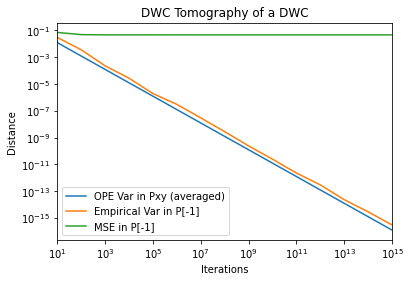

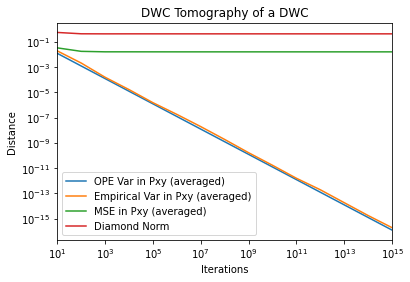

In [6]:

# %% OPE of a DWC with noise
d = 2
M = 100# repeat for each N
noise_lev = 0.5
## Fixing one channel
gamm = 0.7
N_vals = np.linspace(1,15, 15)
Pxy = eig_e_corr(d,gamm)
Pxy.sort()
aaa = Pxy
Pxy = Pxy.reshape((d,d))
#print(Pxy)


var_Pxy = np.mean(aaa*(1-aaa))
N_vals = [round(10**ii) for ii in N_vals]
print(M*len(N_vals), 'total tasks')
dist_dist = np.zeros((M,len(N_vals))) # distance in distribution
norm_dist = np.zeros((M,len(N_vals))) # diamond norm distance
theor_var = np.zeros((len(N_vals))) # theoritical variance in sestimate of first element
x_obs = list(map(OPE_DWC,[[aaa, noise_lev, N_vals[ii]] for ii in range(len(N_vals)) for kk in range(M)])) # Should be divided by d+1
##
################


kkk = -1 # element of Pxy for MSE, Var etc
x_dat = [[x_obs[ii+kk*M].T.tolist()[0] for kk in range(len(N_vals))] for ii in range(M)]

emp_var2 = [[x_obs[ii+kk*M][kkk].tolist() for ii in range(M)] for kk in range(len(N_vals))]

mse_0 = [[(x_obs[ii+kk*M][kkk].tolist() - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))]
for ii in range(len(N_vals)):
    theor_var[ii] =var_Pxy/N_vals[ii]

emp_var2 = np.var(emp_var2, axis = 1)
mse_0 = np.mean(mse_0, axis = 1)

plt.loglog(N_vals, theor_var, label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in P["+ str(kkk) + "]")
plt.loglog(N_vals, mse_0, label="MSE in P[" + str(kkk) + "]")


plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

plt.figure()
#kkk = -1 # element of Pxy for MSE, Var etc

emp_var2 = []
mse_0 = []

d_norm_anal_v = list(map(d_norm_anal, [(Pxy,  x_obs[kk], d) 
                                   for kk in range(len(x_obs))]))

d_norm_anal_p = np.mean(np.reshape(d_norm_anal_v, [len(N_vals), M]), axis = 1) # plot d_norm

asd = list(map(empVar,[[x_obs, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.mean(asd,axis=0)

asd = list(map(mmse,[[x_obs, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.mean(asd,axis = 0)

mse_no_mit = mse_0

#emp_var2 = np.mean(emp_var2, axis = 0)
#mse_0 = np.mean(mse_0, axis = 0)
plt.loglog(N_vals, theor_var, label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")
plt.loglog(N_vals, d_norm_anal_p, label = "Diamond Norm")

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()


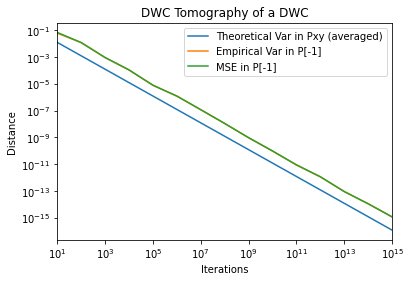

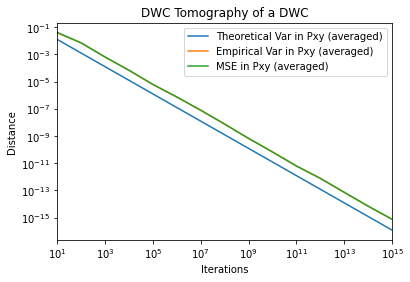

In [8]:
##### Noise mitigation

noise_correct = noise_lev

######################
## Noise Correction ##
######################
x_obs_corr = [kk/(1 - noise_correct) - noise_correct/((1 - noise_correct)*d**2) for kk in x_obs] # Only bias mitigation
x_obs_corr = [kk.clip(min = 0) for kk in x_obs_corr]
x_obs_corr = [kk/np.sum(kk) for kk in x_obs_corr]
######################
emp_var2 = [[x_obs_corr[ii+kk*M][kkk].tolist() for ii in range(M)] for kk in range(len(N_vals))]

mse_0 = [[(x_obs_corr[ii+kk*M][kkk].tolist() - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))]

emp_var2 = np.var(emp_var2, axis = 1)
mse_0 = np.mean(mse_0, axis = 1)

#plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in P["+ str(kkk) + "]")
plt.loglog(N_vals, mse_0, label="MSE in P[" + str(kkk) + "]")


plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

plt.figure()



asd = list(map(empVar,[[x_obs_corr, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.mean(asd,axis=0)

asd = list(map(mmse,[[x_obs_corr, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.mean(asd,axis = 0)

mse_mit_norm = mse_0

#plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")


plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()


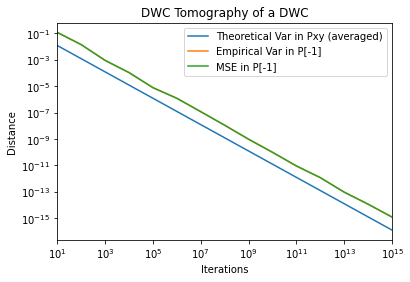

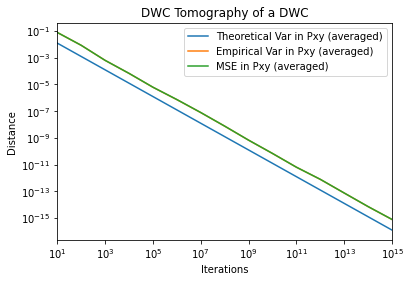

In [10]:
##### Noise mitigation

noise_correct = noise_lev

######################
## Noise Correction ##
######################
x_obs_corr = [kk/(1 - noise_correct) - noise_correct/((1 - noise_correct)*d**2) for kk in x_obs] # Only bias mitigation
#x_obs_corr = [kk.clip(min = 0) for kk in x_obs_corr]
#x_obs_corr = [kk/np.sum(kk) for kk in x_obs_corr]
######################

emp_var2 = [[x_obs_corr[ii+kk*M][kkk].tolist() for ii in range(M)] for kk in range(len(N_vals))]

mse_0 = [[(x_obs_corr[ii+kk*M][kkk].tolist() - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))]

#dist_dist = [[sum(abs(x_obs_corr[ii+kk*M].tolist()[0][0] - aaa))**2 for ii in range(M)] for kk in range(len(N_vals))]
#for ii in range(len(N_vals)):
#    theor_var[ii] =var_Pxy*len(idx_opers)/N_vals[ii]

emp_var2 = np.var(emp_var2, axis = 1)
mse_0 = np.mean(mse_0, axis = 1)

#plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in P["+ str(kkk) + "]")
plt.loglog(N_vals, mse_0, label="MSE in P[" + str(kkk) + "]")


plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

plt.figure()



asd = list(map(empVar,[[x_obs_corr, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.mean(asd,axis=0)

asd = list(map(mmse,[[x_obs_corr, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.mean(asd,axis = 0)

mse_mit = mse_0

#plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")


plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()
#fname = "PTDWC/NvsMSE_d_" + str(d) + "_noise_" + str(noise_lev) + "_gamm_" + str(gamm) +".csv"
#data_save = np.array([N_vals, theor_var/len(idx_opers), theor_var, emp_var2, mse_0]).T
#np.savetxt(fname, data_save, delimiter=",")

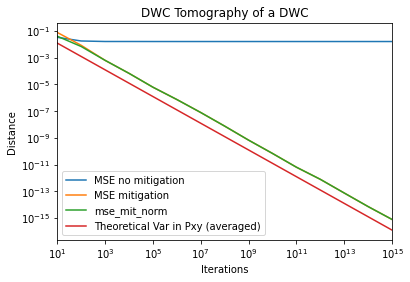

In [11]:
plt.loglog(N_vals, mse_no_mit, label="MSE no mitigation")
plt.loglog(N_vals, mse_mit, label="MSE mitigation")
plt.loglog(N_vals, mse_mit_norm, label="mse_mit_norm")
#plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
#plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()